# Cân bằng dữ liệu cho bài toán dự đoán delay chuyến bay

Notebook này thực hiện việc cân bằng dữ liệu bằng cách undersampling các nhãn 0 và 1 xuống bằng với số lượng của nhãn 2 cho cả tập train và test.

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Khởi tạo Spark Session
spark = SparkSession.builder.appName('DataBalancing') \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

24/12/01 11:39:20 WARN Utils: Your hostname, haveagoodday resolves to a loopback address: 127.0.1.1; using 192.168.1.49 instead (on interface wlan0)
24/12/01 11:39:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 11:39:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Cân bằng dữ liệu train

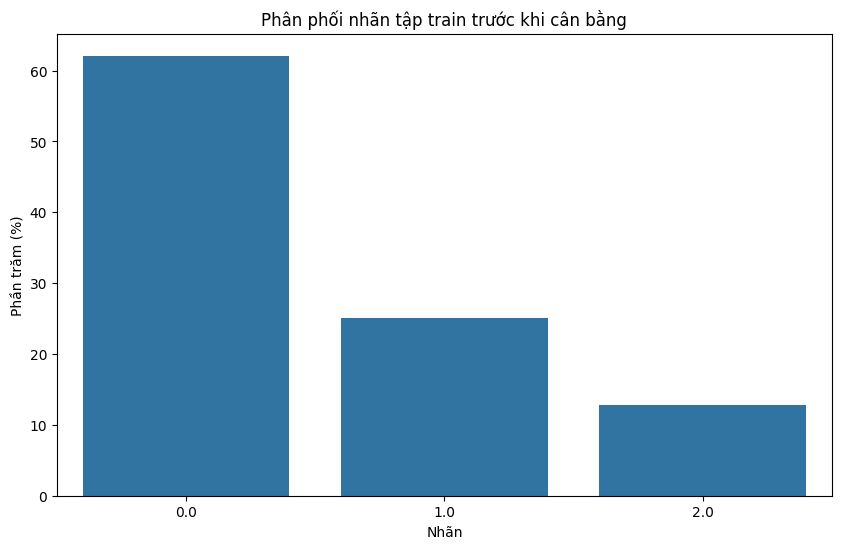

Phân phối nhãn tập train ban đầu: 

   LABEL    count  percentage
0    0.0  4187645   62.099877
1    1.0  1693558   25.114293
2    2.0   862200   12.785829


In [7]:
# Đọc dữ liệu train
schema = '''ID STRING, QUARTER INT, MONTH INT, DAY_OF_MONTH INT, DAY_OF_WEEK INT,
            OP_UNIQUE_CARRIER STRING, ORIGIN STRING, DEST STRING,
            DISTANCE DOUBLE, CRS_DEP_TIME DOUBLE, LABEL DOUBLE'''

df_train = spark.read.csv('/home/snowfox/Documents/kafka/Dataset/train_final.csv', 
                    header=True, schema=schema)

# Hiển thị phân phối dữ liệu train ban đầu
train_counts = df_train.groupBy('LABEL').count().toPandas()
total_train = train_counts['count'].sum()
train_counts['percentage'] = train_counts['count'] / total_train * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='LABEL', y='percentage', data=train_counts)
plt.title('Phân phối nhãn tập train trước khi cân bằng')
plt.xlabel('Nhãn')
plt.ylabel('Phần trăm (%)')
plt.show()

print("Phân phối nhãn tập train ban đầu: \n")
print(train_counts)

In [6]:
# Cân bằng dữ liệu train
train_label_0 = df_train.filter(col("LABEL") == 0)
train_label_1 = df_train.filter(col("LABEL") == 1)
train_label_2 = df_train.filter(col("LABEL") == 2)

count_train_label_2 = train_label_2.count()

train_label_0_sampled = train_label_0.orderBy(rand()).limit(count_train_label_2)
train_label_1_sampled = train_label_1.orderBy(rand()).limit(count_train_label_2)

df_train_balanced = train_label_0_sampled.union(train_label_1_sampled).union(train_label_2)

df_train_balanced = df_train_balanced.orderBy(rand())

# Hiển thị phân phối sau khi cân bằng
train_balanced_counts = df_train_balanced.groupBy('LABEL').count().toPandas()
total_train = train_balanced_counts['count'].sum()
train_balanced_counts['percentage'] = train_balanced_counts['count'] / total_train * 100
print("\nPhân phối nhãn tập train sau khi cân bằng: \n")
print(train_balanced_counts)


Phân phối nhãn tập train sau khi cân bằng: 

   LABEL   count  percentage
0    0.0  862200   33.333333
1    1.0  862200   33.333333
2    2.0  862200   33.333333


## 2. Cân bằng dữ liệu stream (test)

In [3]:
# Đọc dữ liệu stream
df_stream = spark.read.csv('/home/snowfox/Documents/kafka/Dataset/stream_final.csv', 
                    header=True, schema=schema)

# Hiển thị phân phối dữ liệu stream ban đầu
stream_counts = df_stream.groupBy('LABEL').count().toPandas()
total_stream = stream_counts['count'].sum()
stream_counts['percentage'] = stream_counts['count'] / total_stream * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='LABEL', y='percentage', data=stream_counts)
plt.title('Phân phối nhãn tập stream trước khi cân bằng')
plt.xlabel('Nhãn')
plt.ylabel('Phần trăm (%)')
plt.show()

print("Phân phối nhãn tập stream ban đầu:")
print(stream_counts)

NameError: name 'schema' is not defined

In [6]:
# Cân bằng dữ liệu stream
stream_label_0 = df_stream.filter(col("LABEL") == 0)
stream_label_1 = df_stream.filter(col("LABEL") == 1)
stream_label_2 = df_stream.filter(col("LABEL") == 2)

count_stream_label_2 = stream_label_2.count()

stream_label_0_sampled = stream_label_0.orderBy(rand()).limit(count_stream_label_2)
stream_label_1_sampled = stream_label_1.orderBy(rand()).limit(count_stream_label_2)

df_stream_balanced = stream_label_0_sampled.union(stream_label_1_sampled).union(stream_label_2)

df_stream_balanced = df_stream_balanced.orderBy(rand())

# Hiển thị phân phối sau khi cân bằng
stream_balanced_counts = df_stream_balanced.groupBy('LABEL').count().toPandas()
print("\nPhân phối nhãn tập stream sau khi cân bằng:")
print(stream_balanced_counts)


Phân phối nhãn tập stream sau khi cân bằng:
   LABEL   count
0    0.0  273842
1    1.0  273842
2    2.0  273842


In [7]:
# Lưu dữ liệu đã cân bằng
train_output_path = '/home/snowfox/Documents/kafka/Dataset/train_balanced.csv'
stream_output_path = '/home/snowfox/Documents/kafka/Dataset/stream_balanced.csv'

# Chuyển DataFrame Spark thành Pandas DataFrame và lưu dưới dạng CSV
df_train_balanced.toPandas().to_csv(train_output_path, index=False)
df_stream_balanced.toPandas().to_csv(stream_output_path, index=False)

print(f"Đã lưu dữ liệu train cân bằng tại: {train_output_path}")
print(f"Đã lưu dữ liệu stream cân bằng tại: {stream_output_path}")

Đã lưu dữ liệu train cân bằng tại: /home/snowfox/Documents/kafka/Dataset/train_balanced.csv
Đã lưu dữ liệu stream cân bằng tại: /home/snowfox/Documents/kafka/Dataset/stream_balanced.csv
